# Forecasting NYC Weather

In [39]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from math import sqrt
from datetime import datetime
import requests
import json
from decouple import config

plt.style.use('tableau-colorblind10')

In [41]:
# pull the NOAA token from the environment variable (.env)
noaa_token = config('NOAA_TOKEN')

In [36]:
#initialize lists to store data
dates_temp = []
dates_prcp = []
temps = []
prcp = []

#for each year from 2016-2020 ...
for year in range(2016,2021):
    year = str(year)
    print('Working on year '+year)
    
    #make the api call
    r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG&limit=1000&stationid=GHCND:USW00014732&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':noaa_token})
    #load the api response as a json
    d = json.loads(r.text)
    #get all items in the response which are average temperature readings
    avg_temps = [item for item in d['results'] if item['datatype']=='TAVG']
    #get the date field from all average temperature readings
    dates_temp += [item['date'] for item in avg_temps]
    #get the actual average temperature from all average temperature readings
    temps += [item['value'] for item in avg_temps]

working on year 2016
working on year 2017
working on year 2018
working on year 2019
working on year 2020


In [37]:
#initialize dataframe
df_temp = pd.DataFrame()

#populate date and average temperature fields (cast string date to datetime and convert temperature from tenths of Celsius to Fahrenheit)
df_temp['date'] = [datetime.strptime(d, "%Y-%m-%dT%H:%M:%S") for d in dates_temp]
df_temp['avgTemp'] = [float(v)/10.0*1.8 + 32 for v in temps]

In [38]:
df_temp

,date,avgTemp
0,2016-01-01,41.90
1,2016-01-02,37.22
2,2016-01-03,39.92
3,2016-01-04,33.62
4,2016-01-05,19.58
...,...,...
1822,2020-12-27,31.64
1823,2020-12-28,42.98
1824,2020-12-29,42.08
1825,2020-12-30,35.24


In [73]:
daily_avg_temps = df_temp.groupby('date')['avgTemp'].mean()
daily_avg_temps

date
2016-01-01    41.90
2016-01-02    37.22
2016-01-03    39.92
2016-01-04    33.62
2016-01-05    19.58
              ...  
2020-12-27    31.64
2020-12-28    42.98
2020-12-29    42.08
2020-12-30    35.24
2020-12-31    45.86
Name: avgTemp, Length: 1827, dtype: float64

In [74]:
# resample for the monthly average
monthly_avg_temps = daily_avg_temps.resample('M').mean()
monthly_avg_temps

date
2016-01-31    35.646452
2016-02-29    38.225517
2016-03-31    48.298710
2016-04-30    52.502000
2016-05-31    62.907742
2016-06-30    73.124000
2016-07-31    80.286452
2016-08-31    80.756774
2016-09-30    73.514000
2016-10-31    60.741935
2016-11-30    52.214000
2016-12-31    40.425161
2017-01-31    39.490323
2017-02-28    42.266429
2017-03-31    40.651613
2017-04-30    57.014000
2017-05-31    62.797419
2017-06-30    73.382000
2017-07-31    77.638710
2017-08-31    75.118710
2017-09-30    71.024000
2017-10-31    65.032903
2017-11-30    48.104000
2017-12-31    36.302581
2018-01-31    31.523871
2018-02-28    41.443571
2018-03-31    40.425161
2018-04-30    48.830000
2018-05-31    66.385806
2018-06-30    72.470000
2018-07-31    79.427097
2018-08-31    80.570968
2018-09-30    72.350000
2018-10-31    59.534194
2018-11-30    45.812000
2018-12-31    40.529677
2019-01-31    33.753548
2019-02-28    35.535714
2019-03-31    40.744516
2019-04-30    53.318000
2019-05-31    61.276129
2019-06-30 

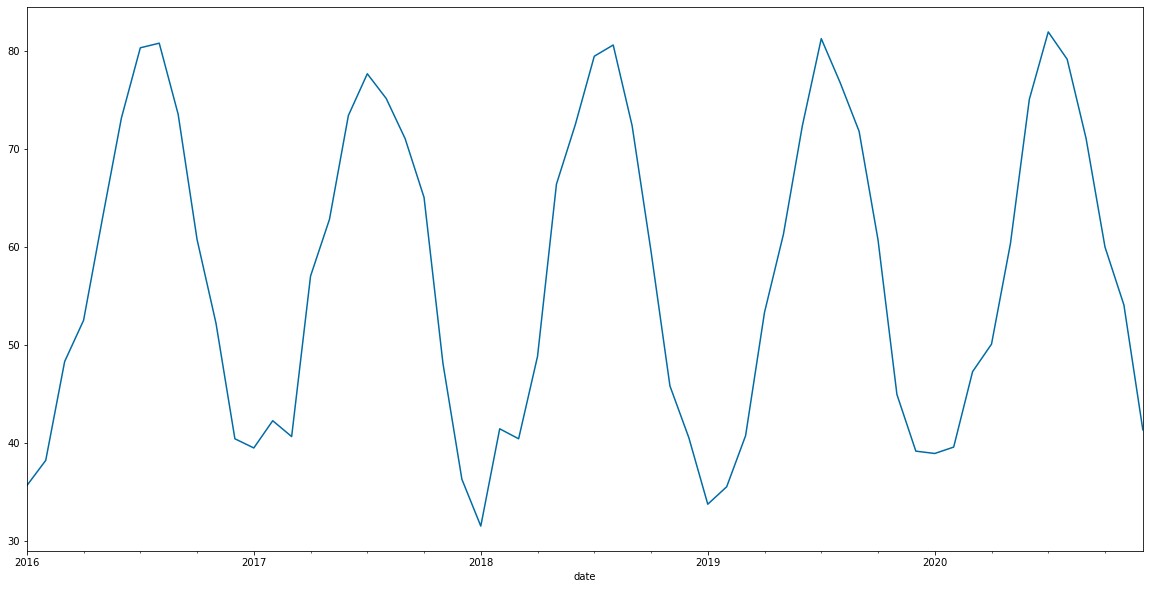

In [75]:
monthly_avg_temps.plot(figsize=(20,10))
plt.show()

In [76]:
monthly_avg_temps.median()

58.274096774193545

In [77]:
monthly_avg_temps.describe()

count    60.000000
mean     57.282049
std      15.752561
min      31.523871
25%      41.193065
50%      58.274097
75%      72.380000
max      81.906452
Name: avgTemp, dtype: float64

In [82]:
# Gridsearch (hyperparameter optimization) for model selection
# Define the p, d and q parameters to take either 0 or 1 as a value
p = d = q = range(0, 2)

In [83]:
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

In [84]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [85]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

param_l = []
param_seasonal_l = []
results_l = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_avg_temps,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            param_l.append(param)
            param_seasonal_l.append(param_seasonal)
            results_l.append(results.aic)
            
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:651.9653906041104
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:484.48266614868015
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:264.5399013952513
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1379.1126815142284
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:271.9844131125877
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:251.2678724503276
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:193.0296700010307
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1247.2445310023659
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:570.510154425951
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:418.75359693864567
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:260.8209306464899
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1321.0628641957792
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:273.97038501309424
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:248.74541237294855
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:194.89527982256172
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1317.3107523495328
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:419.62570550348636
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:316.5142971862295
A

In [86]:
# identify lowest AIC value combination
results_df = pd.DataFrame({"param":param_l,
              "param_seasonal":param_seasonal_l,
              "results":results_l})
results_df.sort_values(by=['results']).iloc[0]

param                 (1, 1, 1)
param_seasonal    (1, 1, 0, 12)
results              186.480777
Name: 62, dtype: object

In [119]:
mod = sm.tsa.statespace.SARIMAX(monthly_avg_temps,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0205      0.279     -0.073      0.941      -0.567       0.526
ma.L1         -0.8605      0.132     -6.521      0.000      -1.119      -0.602
ar.S.L12      -0.5238      0.202     -2.590      0.010      -0.920      -0.127
sigma2        10.8890      2.567      4.242      0.000       5.858      15.920


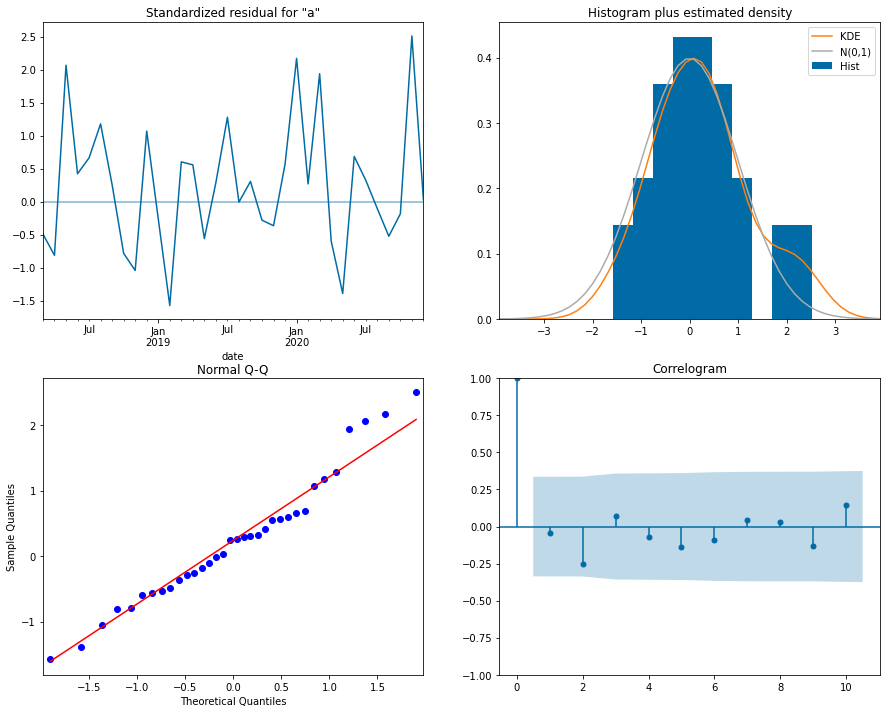

In [120]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [121]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-31'), dynamic=False)
pred_ci = pred.conf_int(alpha=0.25)

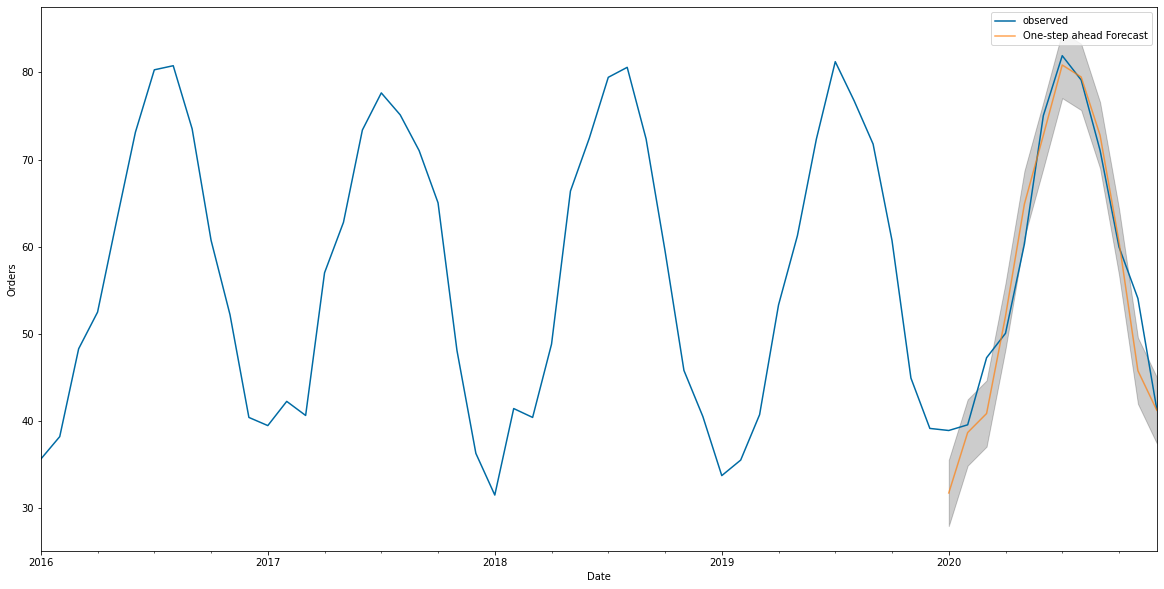

In [122]:
ax = new_weather_df['2000':].plot(label='observed', figsize=(20,10))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Orders')
plt.legend()

plt.show()

In [123]:
new_weather_df_forecasted = pred.predicted_mean
new_weather_df_truth = new_weather_df['2015-01-01':]

# Compute the root mean square error
mse = ((new_weather_df_forecasted - new_weather_df_truth) ** 2).mean()
rmse = sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Root Mean Squared Error of our forecasts is 4.05


### The Root Mean Squared Error is how I am measuring the accuracy of the model. Adjustments in the model that decrease this value indicate those adjustments have created a more accurate model.

In [129]:
# Get forecast 24 steps ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int(alpha=0.5)

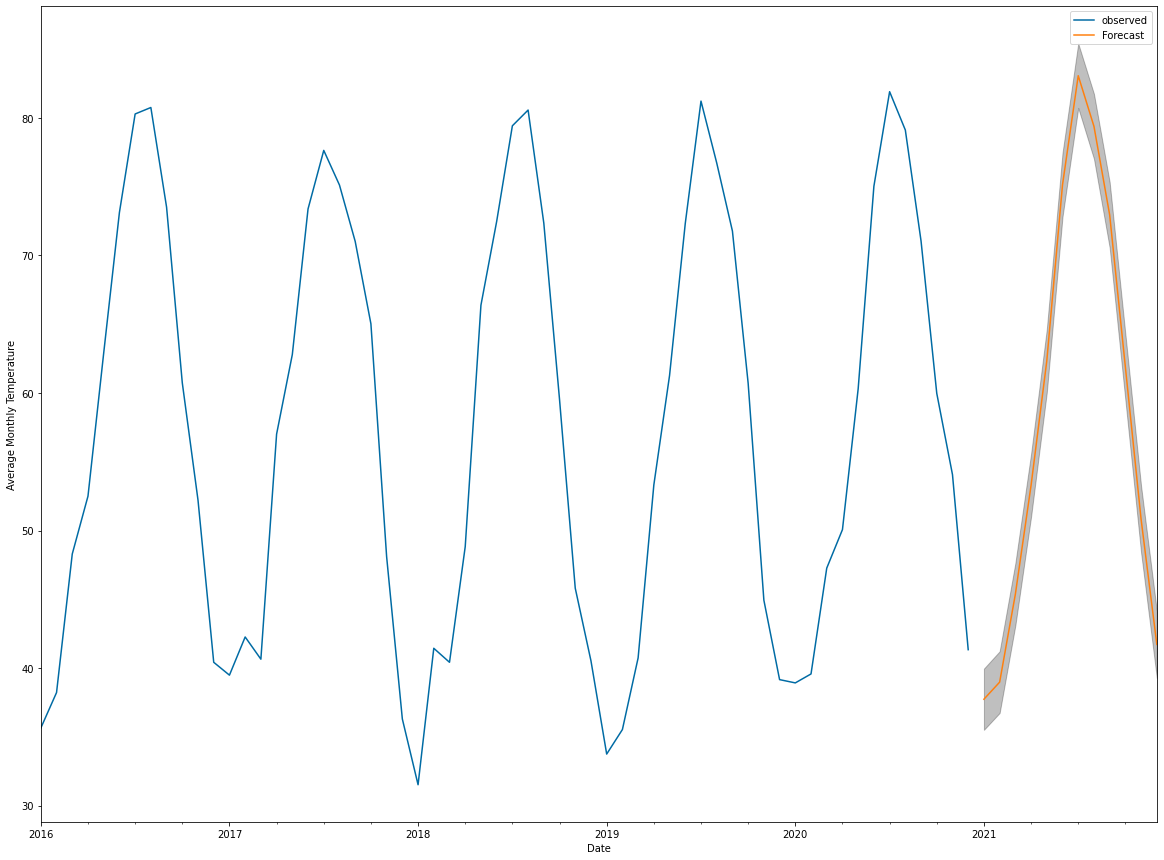

In [130]:
ax = new_weather_df.plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Average Monthly Temperature')

plt.legend()
plt.show()

In [131]:
# Predict next month in the dataset
pred_uc = results.get_forecast()
pred_uc.predicted_mean.astype(float)

2021-01-31    37.740955
Freq: M, dtype: float64

In [132]:
# Predict next 12 months
pred_uc = results.get_forecast(steps=12)
pred_uc.predicted_mean.astype(float)

2021-01-31    37.740955
2021-02-28    38.983420
2021-03-31    45.375011
2021-04-30    53.294459
2021-05-31    62.339430
2021-06-30    75.140184
2021-07-31    83.069927
2021-08-31    79.388722
2021-09-30    72.950585
2021-10-31    61.884050
2021-11-30    50.810505
2021-12-31    41.724472
Freq: M, Name: predicted_mean, dtype: float64